In [0]:
# Load Required Libraries
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 

import seaborn as sns   # Heatmap plot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score

C:\Users\bchandrasekaran\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [0]:
# Read Dataset csv file
rawdataset = pd.read_csv('dataset2\dataset.csv')

In [0]:
# Plotting Sub-function to display Performance Metrics
def Plot_Precision_Recall_Curve(precision, recall,averagePrecision):
    plt.clf()
    plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          averagePrecision))
    plt.show()

def plot_TrainTestAccuracy(xs, train_accuracy_list, dev_accuracy_list):
    plt.clf()
    plt.plot(xs, train_accuracy_list, label='train')
    plt.plot(xs, dev_accuracy_list, label='dev')
    plt.xlabel('Tuning Parameter')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_PrecisionRecall(xs, dev_precision_list, dev_recall_list):
    plt.clf()
    plt.plot(xs, dev_precision_list, label='Precision')
    plt.plot(xs, dev_recall_list, label='recall')
    plt.ylabel('Precision and Recall')
    plt.xlabel(' Tuning Parameter')
    plt.legend()
    plt.show() 

def plot_AUCROCCurve(fpr,tpr,AUC):
    plt.clf()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic' + str(AUC))
    plt.legend(loc="lower right")
    plt.show()    

def plot_kscurve(fpr,tpr):    
    plt.clf()    
    plt.plot([0,1,2,3,4,5,6,7,8,9,10],np.percentile(tpr,[0,10,20,30,40,50,60,70,80,90,100]),color = 'r')
    plt.plot([0,1,2,3,4,5,6,7,8,9,10],np.percentile(fpr,[0,10,20,30,40,50,60,70,80,90,100]), color='navy', linestyle='--')
    plt.title('KS='+str(np.max(tpr - fpr)))
    plt.xlabel('quantile')
    plt.ylabel('FPR or TPR')
    plt.legend(('TPR','FPR'))
    plt.grid()    
    
# Get Error Type
def get_error_type(pred, label):
    # return the type of error: tp,fp,tn,fn
    if pred == label:
        return "tp" if pred == 1 else "tn"
    return "fp" if pred == 1 else "fn"    

# Custom function to get confusion Matrix     
def get_custom_confusionMatrix(predicted, truelabel):
    confusion_mat = np.zeros((2, 2))
    
    for k in range(0,len(predicted)):
        val = get_error_type(predicted[k], truelabel[k])
        if val == "tp":     
            confusion_mat[0][0] = confusion_mat[0][0] + 1
        elif val == "fp":     
            confusion_mat[0][1] = confusion_mat[0][1] + 1
        elif val == "fn":         
            confusion_mat[1][0] = confusion_mat[1][0] + 1
        else:
            confusion_mat[1][1] = confusion_mat[1][1] + 1
            
    return(confusion_mat)             

In [0]:
# Define Target Variable
# Fully paid or Current means 0 Rest categories as 1 (Default)
columnsTarget = ['loan_status']
subset_Target = pd.DataFrame(rawdataset,columns=columnsTarget)

label_encoder   = LabelEncoder()
integer_encoded = label_encoder.fit_transform(subset_Target)

for k in range(0,6):
    print("Integer Encoded:", k, label_encoder.inverse_transform(k))

TargetVar = []
for k in range(0,len(integer_encoded)):
    tempvar = 1
    if integer_encoded[k] == 1 or  integer_encoded[k] == 3 :   # Current or Fully Paid
        tempvar = 0
    TargetVar.append(tempvar)


C:\Users\bchandrasekaran\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\bchandrasekaran\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\bchandrasekaran\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\bchandrasekaran\AppData\Local\Continuum\Anaconda3\lib\site-packages

Integer Encoded: 0 Charged Off
Integer Encoded: 1 Current
Integer Encoded: 2 Default
Integer Encoded: 3 Fully Paid
Integer Encoded: 4 Late (16-30 days)
Integer Encoded: 5 Late (31-120 days)


In [0]:
# Create sub-frame organized data
# Character Catergory subset
columnscharacter = ['delinq_2yrs','inq_last_6mths','open_acc','revol_bal','revol_util', 'tot_cur_bal']   
# Conditions Cateory subset
columnscond       = ['loan_amnt','int_rate','grade','term','purpose']
# capacity Cateory subset
columnscapactity  = ['emp_length','annual_inc_merged','dti_merged']

# Collateral Category subset
columnscollateral = ['home_ownership']

# New Variables Unsorted
newvars = ['collections_12_mths_ex_med','earliest_cr_line_elapseddays']  

columns_sub = columnscharacter
columns_sub.extend(columnscapactity)
columns_sub.extend(columnscollateral)
columns_sub.extend(columnscond)

columns_sub.extend(newvars)

subsetdf    = pd.DataFrame(rawdataset,columns=columns_sub)

print(subsetdf.dtypes)

# Fill Null Values with Mean
for col in subsetdf.columns:
    if subsetdf[col].dtype == np.float64 or subsetdf[col].dtype == np.int64 :
        if subsetdf[col].isnull().sum(axis=0) > 0 :
            meanval = subsetdf[col].mean()
            subsetdf[col] = subsetdf[col].fillna(meanval,inplace=False)

# Replace Home Ownership into Collateral Possible 
subsetdf['home_ownership'].replace(to_replace='OWN', value='COLLPOSSIBLE', regex=True, inplace=True)
subsetdf['home_ownership'].replace(to_replace='MORTGAGE', value='COLLPOSSIBLE', regex=True, inplace=True)
subsetdf['home_ownership'].replace(to_replace='RENT', value='COLLNOTPOSSIBLE', regex=True, inplace=True)
subsetdf['home_ownership'].replace(to_replace='OTHER', value='COLLNOTPOSSIBLE', regex=True, inplace=True)
subsetdf['home_ownership'].replace(to_replace='NONE', value='COLLNOTPOSSIBLE', regex=True, inplace=True)


# Encode all Catrgorical Variables
subsetdf = pd.get_dummies(subsetdf,columns=['home_ownership'])
subsetdf = pd.get_dummies(subsetdf,columns=['term'])
subsetdf = pd.get_dummies(subsetdf,columns=['grade'])
subsetdf = pd.get_dummies(subsetdf,columns=['purpose'])

# Create Normalized data frame
subsetdf_Normalized = subsetdf

# Add Target Variable
target_series = pd.Series(TargetVar)
target_series.index = subsetdf.index

# Normalize Dataset (Mean and std)
for col in subsetdf_Normalized:
    if subsetdf_Normalized[col].dtype == np.float64 or subsetdf[col].dtype == np.int64 :
        meanval = np.mean(subsetdf_Normalized[col])
        stdval  = np.std(subsetdf_Normalized[col])  
        subsetdf_Normalized[col] = (subsetdf_Normalized[col] - meanval)/stdval

# Add Target Variable
target_series = pd.Series(TargetVar)
target_series.index = subsetdf_Normalized.index
subsetdf_Normalized['TARGET'] = target_series

delinq_2yrs                       int64
inq_last_6mths                    int64
open_acc                          int64
revol_bal                         int64
revol_util                      float64
tot_cur_bal                     float64
emp_length                        int64
annual_inc_merged               float64
dti_merged                      float64
home_ownership                   object
loan_amnt                         int64
int_rate                        float64
grade                            object
term                             object
purpose                          object
collections_12_mths_ex_med      float64
earliest_cr_line_elapseddays      int64
dtype: object


In [0]:
# Print to show Imbalance in distribution
tempvar = subsetdf_Normalized['TARGET'].values

print(len(tempvar))
print(tempvar[1:10])

print(np.sum(tempvar))


869914
[1 0 0 0 0 0 0 1 1]
60415


In [0]:
# Drop Target Variavle from input parameter
y = subsetdf_Normalized['TARGET'].values            # Output Target
subsetdf_Normalized = subsetdf_Normalized.drop(['TARGET'],axis=1)
train_x, test_x,train_y, test_y = train_test_split(subsetdf_Normalized,y,test_size = 0.2, random_state  = 42)

print(len(train_x))
print(len(test_x))

695931
173983


In [0]:
# Try Logistic Regression Algorithm and Pick the best Parameter based on dev dataset
cs = np.logspace(1, -3, num=10)

train_accuracy_list = list()
dev_accuracy_list = list()

dev_recall_list = list()
dev_precision_list = list()

for c in cs:
    model = LogisticRegression(C = c)
    model.fit(train_x,train_y)
    train_preds = model.predict(train_x)
    dev_preds   = model.predict(test_x)

    (train_score, dev_score) = (accuracy_score(train_y, train_preds), accuracy_score(test_y, dev_preds))
    
    # Find Recall and Precision Scores  
    train_score_r = recall_score(train_y, train_preds, pos_label=1, average="binary")
    train_score_p = precision_score(train_y, train_preds, pos_label=1, average="binary")
    
    dev_score_r = recall_score(test_y, dev_preds, pos_label=1, average="binary")
    dev_score_p = precision_score(test_y, dev_preds, pos_label=1, average="binary")
    
    # Collect Train and Dev Accuracy
    train_accuracy_list.append(train_score)
    dev_accuracy_list.append(dev_score)
    
    # Collect dev Precision and Recall 
    dev_recall_list.append(dev_score_r)
    dev_precision_list.append(dev_score_p)
    
    print("Train Accuracy:", train_score, ", Dev Accuracy:", dev_score, ",param:", c)
    print("Train Recall:", train_score_r, ", Train Precision:", train_score_p, ",param:", c)
    print("Dev Recall:", dev_score_r, ", Dev Precision:", dev_score_p, ",param:", c)



Train Accuracy: 0.9306324908647553 , Dev Accuracy: 0.9300793755711765 ,param: 10.0
Train Recall: 0.00014507772020725388 , Train Precision: 0.1794871794871795 ,param: 10.0
Dev Recall: 0.0004110152075626798 , Dev Precision: 0.5 ,param: 10.0
Train Accuracy: 0.9306324908647553 , Dev Accuracy: 0.9300793755711765 ,param: 3.5938136638046276
Train Recall: 0.00014507772020725388 , Train Precision: 0.1794871794871795 ,param: 3.5938136638046276
Dev Recall: 0.0004110152075626798 , Dev Precision: 0.5 ,param: 3.5938136638046276
Train Accuracy: 0.9306324908647553 , Dev Accuracy: 0.9300793755711765 ,param: 1.291549665014884
Train Recall: 0.00014507772020725388 , Train Precision: 0.1794871794871795 ,param: 1.291549665014884
Dev Recall: 0.0004110152075626798 , Dev Precision: 0.5 ,param: 1.291549665014884
Train Accuracy: 0.9306324908647553 , Dev Accuracy: 0.9300793755711765 ,param: 0.464158883361278
Train Recall: 0.00014507772020725388 , Train Precision: 0.1794871794871795 ,param: 0.464158883361278
Dev R

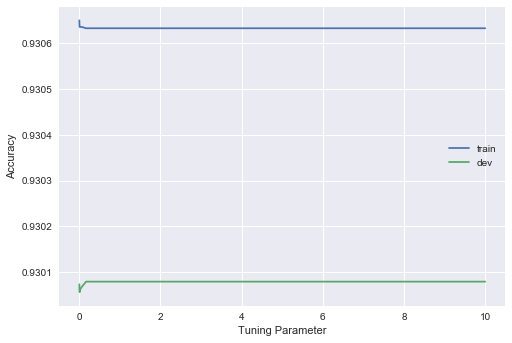

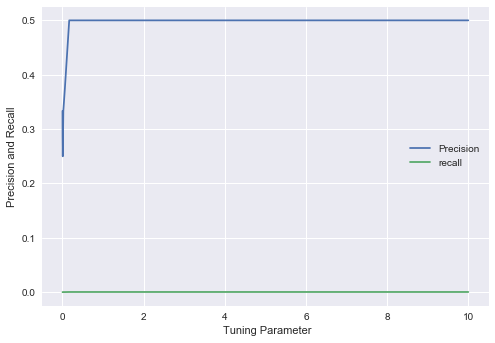

In [0]:
# Plot Train, Test Accuracy; Test set Precision and Recall scores
plot_TrainTestAccuracy(cs, train_accuracy_list, dev_accuracy_list)
plot_PrecisionRecall(cs,dev_precision_list, dev_recall_list)


In [0]:
# Pick the Performance Parameter
best_model = LogisticRegression(C=cs[np.argmax(dev_accuracy_list)])  
best_model.fit(train_x,train_y)
dev_preds  = best_model.predict(test_x)

dev_preds_Prob  = best_model.predict_proba(test_x)

print("Best Model Performance:")

dev_accuracy = accuracy_score(test_y, dev_preds)
dev_score_r  = recall_score(test_y, dev_preds, pos_label=1, average="binary")
dev_score_p  = precision_score(test_y, dev_preds, pos_label=1, average="binary")
print("Dev Recall:", dev_score_r, ", Dev Precision:", dev_score_p, ",Accuracy:", dev_accuracy)

print("ROC Score")
print (roc_auc_score(test_y,dev_preds))


Best Model Performance:
Dev Recall: 0.0004110152075626798 , Dev Precision: 0.5 ,Accuracy: 0.9300793755711765
ROC Score
0.5001900581482202


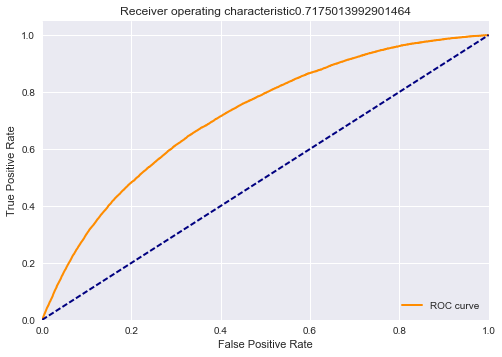

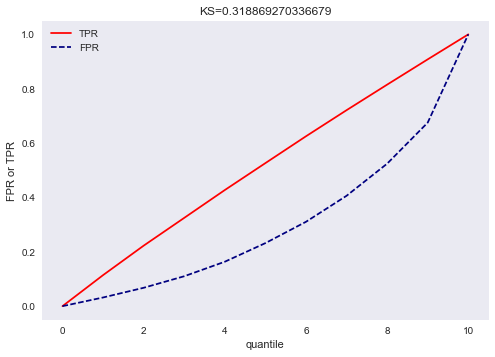

In [0]:
# Plot Train, Test Accuracy; Test set Precision and Recall scores
# plot_TrainTestAccuracy(cs, train_accuracy_list, dev_accuracy_list)
# plot_PrecisionRecall(cs,dev_precision_list, dev_recall_list)

# Plot AUC , ROC Curve results
fpr, tpr, _ = roc_curve(test_y, dev_preds_Prob[:,1])
plot_AUCROCCurve(fpr,tpr,roc_auc_score(test_y,dev_preds_Prob[:,1]))
plot_kscurve(fpr,tpr)

In [0]:
# Print Confusion Matrix for Performance Analysis
cfmatrix = get_custom_confusionMatrix(dev_preds,test_y.ravel())
print(cfmatrix)

print("tp:", int(cfmatrix[0][0]), ", fp:", int(cfmatrix[0][1]),", fn:", int(cfmatrix[1][0]),", tn:", int(cfmatrix[1][1]))


[[5.00000e+00 5.00000e+00]
 [1.21600e+04 1.61813e+05]]
tp: 5 , fp: 5 , fn: 12160 , tn: 161813
